As we have seen in our 1st notebook that our model, ResNet-50 built from scratch, didnt perform well on due to imbalanced training dataset.

So inorder to tackle the imbalanced dataset problem, in our 2nd notebook we applied data augmentation alongwith the custom agumentation which yielded much better results.

But in **this notebook** we'll implement some other technique to handle the imbalanced dataset. Below are the tactics to be used:

* We'll use **only the weights of pre-trained ResNet-50 weights** alongwith **custom augmentation** of the images to help the model generalize better.

* We'll also finetune it by:
  * increasing the number of epochs to 100
  * increasing the batch size to 32
  * changing the learning rate to 1e-3
  * replacing dropout with **regularization**

We'll then again train our model on the custom dataset, and find out how it performs on our test dataset.

In [ ]:
!pip install torchvision

In [ ]:
import tensorflow_datasets as tfds
import logging
from zipfile import ZipFile
import os
import sys
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#from utils.events import download_google_drive_file

In [ ]:
import os
os.listdir('/kaggle/input/deepweeds-image-classification')


['train_subset1.csv',
 'test_subset1.csv',
 'val_subset0.csv',
 'test_subset0.csv',
 'train_subset0.csv',
 'images',
 'val_subset1.csv',
 'labels.csv']

In [ ]:
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image
import torch
from torchvision import transforms
import torchvision
from torchvision import models
import torch.nn as nn
import torch.optim as optim


## Applying Custom Augmentation:

**Below code snippet** implements a more sophisticated and customizable data augmentation pipeline.

It integrates both **PyTorch's transforms** and **custom OpenCV-based transformations** for augmenting images. Additionally, it includes a custom dataset class and creates data loaders to handle images and labels efficiently for training, validation, and testing.

In [ ]:
## Custom OpenCV-Based Augmentation:

import torch
import torchvision.transforms as transforms
import random
import cv2
import numpy as np
from PIL import Image

# Define a custom augmentation function for OpenCV transformations
def random_perspective(img):
    """Apply random perspective transformation using OpenCV."""
    h, w = img.shape[:2]
    # Define the perspective transformation
    src_pts = np.float32([[0, 0], [w, 0], [w, h], [0, h]])
    dst_pts = np.float32([[random.uniform(-0.1, 0.1) * w, random.uniform(-0.1, 0.1) * h] for _ in range(4)])
    matrix = cv2.getPerspectiveTransform(src_pts, dst_pts)
    img = cv2.warpPerspective(img, matrix, (w, h))
    return img

# Function to perform augmentations including OpenCV-based perspective shift
class CustomAugmentations:
    def __init__(self):
        # Define transformations from torchvision.transforms
        self.transforms = transforms.Compose([
            transforms.Resize((128, 128)),  # Resize all images to 256x256
            transforms.RandomRotation(degrees=360),  # Rotate randomly within [-360, +360]
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0),  # Color shifts
            transforms.RandomHorizontalFlip(p=0.5),  # Horizontal flip with 50% probability
        ])

    def __call__(self, img):
        # Convert PIL image to OpenCV format (numpy array)
        img = np.array(img)
        # Perform random perspective transformation using OpenCV
        img = random_perspective(img)
        # Convert back to PIL image for further processing
        img = Image.fromarray(img)
        # Apply remaining torchvision transformations
        img = self.transforms(img)
        # Convert the image to a tensor
        img = transforms.ToTensor()(img)
        # Pixel intensity shift [-25, +25] and scaling [0.75, 1.25]
        img = self.random_pixel_intensity_shift(img)

        return img

    def random_pixel_intensity_shift(self, img):
        """Shift pixel intensity uniformly across all channels and scale within [0.75, 1.25]."""
        # Pixel intensity shift in range [-25, +25]
        intensity_shift = random.uniform(-25 / 255.0, 25 / 255.0)
        img = torch.clamp(img + intensity_shift, 0, 1)
        # Pixel intensity scaling in range [0.75, 1.25]
        intensity_scale = random.uniform(0.75, 1.25)
        img = torch.clamp(img * intensity_scale, 0, 1)

        return img

# Custom dataset class
class ImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data_frame.iloc[idx, 0])
        image = Image.open(img_name)
        label = int(self.data_frame.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, label

# Load the CSV file

train_csv_file = '/kaggle/input/deepweeds-image-classification/train_subset0.csv'  # Replace with your actual path
test_csv_file = '/kaggle/input/deepweeds-image-classification/test_subset0.csv'  # Replace with your actual path
val_csv_file = '/kaggle/input/deepweeds-image-classification/val_subset0.csv'  # Replace with your actual path
img_dir = '/kaggle/input/deepweeds-image-classification/images'  # Replace with your images directory


# Image transformations (resize, normalization, etc.)
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resizing to 128x128, you can adjust this
    transforms.RandomRotation(degrees=360),  # Rotate randomly within [-360, +360]
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0),  # Color shifts
    transforms.RandomHorizontalFlip(p=0.5),  # Horizontal flip with 50% probability
    transforms.ToTensor(),  # Convert the image to PyTorch tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
  ])

# Create an instance of the custom augmentations
custom_augmentations = CustomAugmentations()

# Create the train and test datasets
train_dataset = ImageDataset(csv_file=train_csv_file, img_dir=img_dir, transform=transform)
test_dataset = ImageDataset(csv_file=test_csv_file, img_dir=img_dir, transform=transform)
val_dataset = ImageDataset(csv_file=val_csv_file, img_dir=img_dir, transform=transform)


# Create DataLoaders for batching
def create_dataloader(loader_type):
  if loader_type=='train':
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    print(f"len train_loader {len(train_loader)}")
    return train_loader
  elif loader_type=='val':
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    return val_loader
  else:
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    return test_loader


# Applying the ResNet-50 Model built from scratch:-

Let us now apply our ResNet-50 model built from scratch (same as in our 1st notebook) but **with** the weights from pre-trained ResNet-50, and **without** the 'dropout rate'.


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class Bottleneck(nn.Module):
    def __init__(self, in_channel, out_channel, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.conv2 = nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.conv3 = nn.Conv2d(out_channel, out_channel * 4, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channel * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet50(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(ResNet50, self).__init__()
        self.in_channel = 64
        self.conv1 = nn.Conv2d(3, self.in_channel, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channel)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def _make_layer(self, block, out_channel, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channel != out_channel * 4:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channel, out_channel * 4, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channel * 4)
            )

        layers = []
        layers.append(block(self.in_channel, out_channel, stride, downsample))
        self.in_channel = out_channel * 4
        for _ in range(1, blocks):
            layers.append(block(self.in_channel, out_channel))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


# Adjusted resnet50 function with FC layer mismatch handling
def resnet50(pretrained=False, num_classes=9, **kwargs):
    model = ResNet50(Bottleneck, [3, 4, 6, 3], num_classes=num_classes, **kwargs)

    if pretrained:
        # Load the pretrained ResNet50 model from torchvision
        pretrained_model = models.resnet50(pretrained=True)

        # Load pretrained state dict, but ignore the weights for the fully connected (fc) layer
        pretrained_dict = pretrained_model.state_dict()
        model_dict = model.state_dict()

        # Filter out the FC layer weights from the pretrained model
        pretrained_dict = {k: v for k, v in pretrained_dict.items() if 'fc' not in k}

        # Load the state dict, ignoring the mismatched FC layer
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)

    # Replace the FC layer with a custom one that matches num_classes
    model.fc = nn.Linear(512 * 4, num_classes)

    return model


# Instantiate the model with 9 output classes
model = resnet50(pretrained=True, num_classes=9)     # Setting 'pre-trained' as True instead of False
print(model)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 175MB/s] 


ResNet50(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1

# Model Compilation and Training:-

Below we'll implement the training and validation loop for a ResNet50 model.

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Loss Function and Optimizer Setup:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)    # Changing the learning rate to le-3 from le-4

# Training History and Device Setup:
history = {
        'train_loss': [],
        'train_accuracy': [],
        'val_loss': [],
        'val_accuracy': []
    }

best_val_accuracy = 0.0
best_model_path = "best_model_preweight.pth"

# Applying regualrization:
lambda_l1 = 0.0001  # Regularization strength for L1
lambda_l2 = 0.0001  # Regularization strength for L2

model = model.to(device)

# Dataloaders:
train_loader = create_dataloader(loader_type='train')
val_loader = create_dataloader(loader_type='val')

for epoch in range(100):            # Increasing the # of epochs to 100 from 25
          model.train()
          running_loss = 0.0
          train_correct = 0
          train_total = 0
          for i, (inputs, targets) in enumerate(train_loader):
              inputs, targets = inputs.to(device), targets.to(device)
              optimizer.zero_grad()
              outputs = model(inputs)
              _, predicted = outputs.max(1)
              loss = criterion(outputs, targets)
              loss.backward()
              optimizer.step()
              #training metrics
              running_loss += loss.item()
              train_total += targets.size(0)
              train_correct += predicted.eq(targets).sum().item()

              if i % 100 == 0:
                  print(f'Epoch [{epoch+1}/100], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

          #training metrics-
          train_loss = running_loss / len(train_loader)
          train_accuracy = train_correct / train_total
          history['train_loss'].append(train_loss)
          history['train_accuracy'].append(train_accuracy)

          # Validation Loop:
          model.eval()
          val_loss = 0.0
          val_correct = 0
          val_total = 0
          with torch.no_grad():
            for inputs, targets in val_loader:
              inputs, targets = inputs.to(device), targets.to(device)
              outputs = model(inputs)
              _, predicted = outputs.max(1)
              loss = criterion(outputs, predicted)

              val_loss += loss.item()
              val_total += targets.size(0)
              val_correct += predicted.eq(targets).sum().item()

          # Calculate accuracy
          val_loss /= len(val_loader)
          val_accuracy = val_correct / val_total
          history['val_loss'].append(val_loss)
          history['val_accuracy'].append(val_accuracy)

          print(f'Epoch [{epoch+1}/100], Validation Accuracy: {val_accuracy:.4f}, Train Accuracy: {train_accuracy:.4f}')

          # Save Best Model / Model Checkpointing:
          if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), best_model_path)
            print(f"New best model saved with Validation Accuracy: {val_accuracy:.4f}")


len train_loader 329
Epoch [1/100], Step [1/329], Loss: 2.3261
Epoch [1/100], Step [101/329], Loss: 1.1085
Epoch [1/100], Step [201/329], Loss: 0.8976
Epoch [1/100], Step [301/329], Loss: 1.0265
Epoch [1/100], Validation Accuracy: 0.6281, Train Accuracy: 0.5646
New best model saved with Validation Accuracy: 0.6281
Epoch [2/100], Step [1/329], Loss: 1.3618
Epoch [2/100], Step [101/329], Loss: 0.7271
Epoch [2/100], Step [201/329], Loss: 0.9604
Epoch [2/100], Step [301/329], Loss: 0.9992
Epoch [2/100], Validation Accuracy: 0.6233, Train Accuracy: 0.6481
Epoch [3/100], Step [1/329], Loss: 1.1245
Epoch [3/100], Step [101/329], Loss: 1.0571
Epoch [3/100], Step [201/329], Loss: 1.0919
Epoch [3/100], Step [301/329], Loss: 0.9008
Epoch [3/100], Validation Accuracy: 0.6707, Train Accuracy: 0.6810
New best model saved with Validation Accuracy: 0.6707
Epoch [4/100], Step [1/329], Loss: 0.6751
Epoch [4/100], Step [101/329], Loss: 0.6441
Epoch [4/100], Step [201/329], Loss: 0.9351
Epoch [4/100], Ste

In [ ]:
history

{'train_loss': [1.2783005201345519,
  0.9810800815063407,
  0.8760022222089913,
  0.780717609682344,
  0.7311748628558359,
  0.6544670019649808,
  0.6398390699121365,
  0.6962368670386746,
  0.5769383669533628,
  0.5504754106415078,
  0.5091333853981053,
  0.5193769109738272,
  0.4778288415318927,
  0.47349809714816626,
  0.46160804756597185,
  0.4207237358332405,
  0.43006485028016894,
  0.41224661220351977,
  0.39350939478645935,
  0.4016359697993403,
  0.37063786530114234,
  0.3661324716764743,
  0.348651107445948,
  0.3507376171104995,
  0.3558113946378412,
  0.3267740914796261,
  0.3128957034493471,
  0.32348030508923314,
  0.3057858684754118,
  0.28516989425504097,
  0.28683320276643004,
  0.2973568585777718,
  0.27451756007765565,
  0.2679641358780825,
  0.2631934066571997,
  0.2834891769638721,
  0.25024337336239844,
  0.25625589363118434,
  0.25281778462570853,
  0.22060071964575526,
  0.3143277123434565,
  0.22038291734968818,
  0.2268172188132639,
  0.2109031727350682,
  0.2

Let's plot the above matrices for visualization.

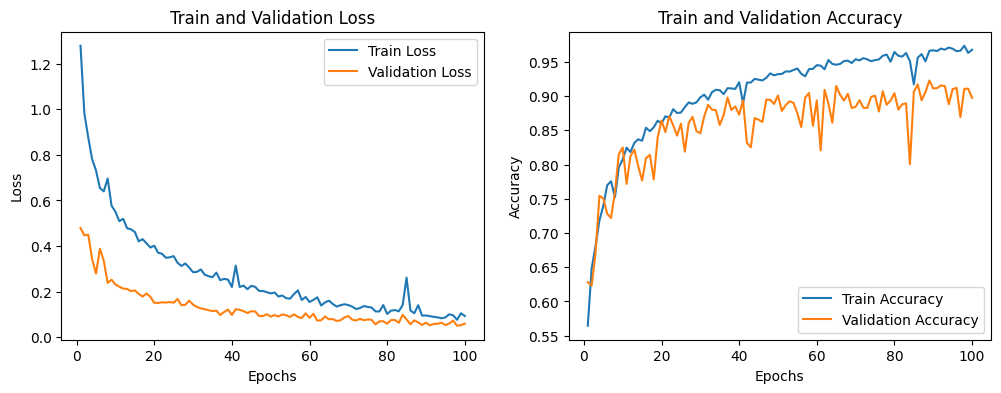

In [ ]:
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_accuracy'], label='Train Accuracy')
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train and Validation Accuracy')
    plt.legend()

    plt.show()

plot_history(history)

So from above we can see that our model does much better than even the 'data augmented' model:
* The training accuracy approaches 0.97 (97%) at the end of the training.
* Wherelese, the validation accuracy fluctuates but ends around 0.90 (90%).

# Testing the model:-

**Let's first test our model on a single image picked randomly.**

/tmp/ipykernel_30/3020517046.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Test Accuracy: 0.9173


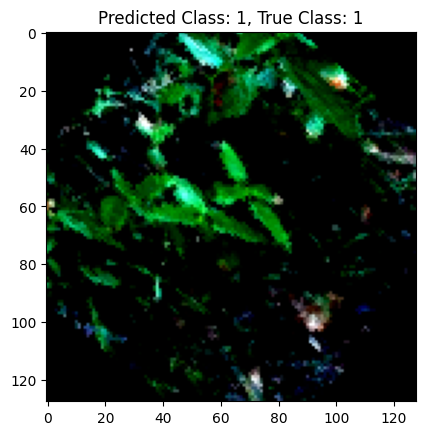

Predicted Class: 1
True Class: 1


In [ ]:
# Load the best model
model.load_state_dict(torch.load(best_model_path))
model.eval()  # Set model to evaluation mode

# Create test loader (assumes a function `create_dataloader` exists)
test_loader = create_dataloader(loader_type='test')

# Evaluate model on the test set
test_correct = 0
test_total = 0

with torch.no_grad():  # Disable gradient calculation for testing
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)  # Get predictions
        test_total += targets.size(0)
        test_correct += predicted.eq(targets).sum().item()

test_accuracy = test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.4f}')

# Choose a random image from the test loader and plot it
dataiter = iter(test_loader)
images, labels = next(dataiter)  # Use next() to get a batch

# Randomly select an image from the batch
random_index = np.random.randint(0, len(images))
image = images[random_index]
label = labels[random_index]

# Move the image to the appropriate device and make prediction
image_tensor = image.unsqueeze(0).to(device)
output = model(image_tensor)
_, predicted_class = output.max(1)

# Convert image to CPU and detach for plotting
image = image.cpu().numpy().transpose((1, 2, 0))  # Convert to numpy array for plotting
image = np.clip(image, 0, 1)  # Normalize pixel values for display

# Plot the image
plt.imshow(image)
plt.title(f'Predicted Class: {predicted_class.item()}, True Class: {label.item()}')
plt.show()

# Print the predicted class
print(f"Predicted Class: {predicted_class.item()}")
print(f"True Class: {label.item()}")

**Now, let's test on a batch of images picked randomly.**

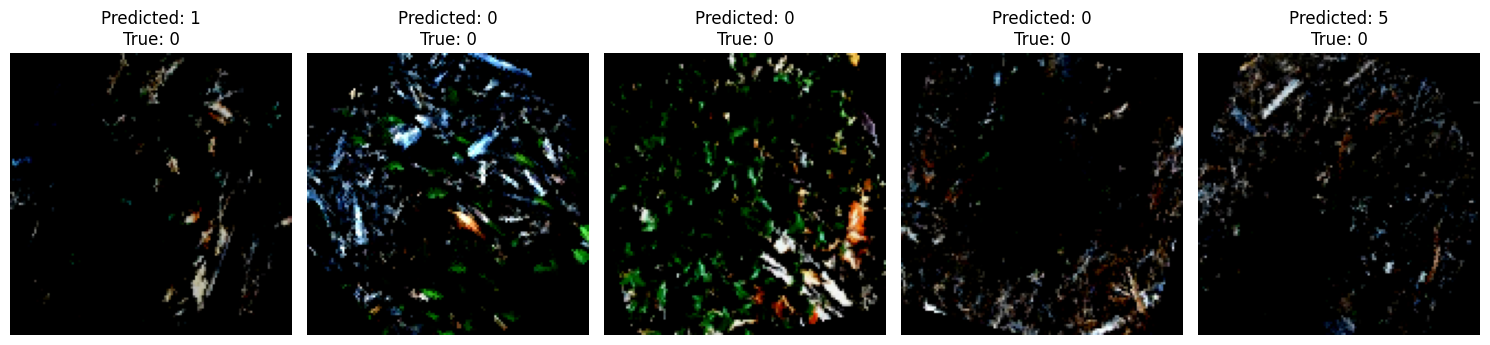

Image 1:
    Predicted Class: 1
    True Class: 0
Image 2:
    Predicted Class: 0
    True Class: 0
Image 3:
    Predicted Class: 0
    True Class: 0
Image 4:
    Predicted Class: 0
    True Class: 0
Image 5:
    Predicted Class: 5
    True Class: 0


In [ ]:
# Evaluate the model on a batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)  # Get a batch of images and their labels

# Move images and labels to the appropriate device
images, labels = images.to(device), labels.to(device)

# Make predictions on the batch
outputs = model(images)
_, predicted_classes = outputs.max(1)

# Convert images back to CPU for visualization
images = images.cpu().numpy().transpose((0, 2, 3, 1))  # Convert to numpy array (N, H, W, C)
images = np.clip(images, 0, 1)  # Normalize pixel values for display

# Plot multiple images with their predicted and true labels
num_images_to_plot = 5  # Number of images to display
fig, axes = plt.subplots(1, num_images_to_plot, figsize=(15, 5))

for idx in range(num_images_to_plot):
    axes[idx].imshow(images[idx])
    axes[idx].set_title(
        f"Predicted: {predicted_classes[idx].item()}\nTrue: {labels[idx].item()}"
    )
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

# Print predictions and true labels for the displayed images
for idx in range(num_images_to_plot):
    print(f"Image {idx + 1}:")
    print(f"    Predicted Class: {predicted_classes[idx].item()}")
    print(f"    True Class: {labels[idx].item()}")